# Twitter Sentiment Analysis for the word rugby

Connect Spark to Mongo DB

In [ ]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars "/usr/local/spark/jars/mongo-spark-connector_2.12-3.0.2.jar,/usr/local/spark/jars/mongo-java-driver-3.12.9.jar" pyspark-shell'

Note the inferschema is set to false, this makes spark read the entire database and not infer the values of fields from the first set of fields

In [ ]:
from pyspark.sql import SparkSession
# fix read bug, basically turn off sampling
spark = SparkSession.builder.appName("TwitterMongo") \
.config("spark.mongodb.input.database", "mongodb://localhost:27017/twitter") \
.config("spark.mongodb.input.uri", "mongodb://localhost:27017/twitter.tweets") \
.config("spark.mongodb.read.sql.inferSchema.mapTypes.enabled", "FALSE") \
.config("spark.mongodb.output.uri","mongodb://localhost:27017/twitter.tweets").getOrCreate()

### Create the Session

And load all of the Twitter data in MongoDB

Print out the twitter tweet schema

In [ ]:
# create a spark session
spark = SparkSession \
.builder \
.master("local") \
.appName("ABC") \
.config("spark.driver.memory", "15g") \
.config("spark.mongodb.read.connection.uri", "mongodb://localhost:27017/twitter") \
.config("spark.mongodb.write.connection.uri", "mongodb://localhost:27017/twitter") \
.config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector:2.12-3.0.2') \
.getOrCreate()
# read data from mongodb collection "questions" into a dataframe "df"
df = spark.read \
.format("com.mongodb.spark.sql.DefaultSource") \
.option("uri", "mongodb://localhost:27017/twitter") \
.option("database", "twitter") \
.option("collection", "tweets") \
.load()
df.printSchema()

In [ ]:
# set up hadoop folder structure

!hadoop fs -test -d /ca4 && hadoop fs -rm -f -R /ca4
!hadoop fs -mkdir /ca4


Create a spark object of the tweets held in the mongo db 

It is easier to use SQL statements and Pyspark to clean the data rather than writing queries in MongoDB

In [ ]:
df.createOrReplaceTempView("tweets")

How many tweets in the DB all together

In [ ]:
df = spark.sql("SELECT DISTINCT id FROM tweets WHERE text LIKE '%rugby%'")
df.count()

How many tweets by language 


In [ ]:
#pip install plotly
%pip install kaleido
import kaleido
import pyspark.pandas as ps
import plotly
dfLang = spark.sql("SELECT DISTINCT lang, CAST(count(id) AS INT) as TweetCount FROM tweets \
            WHERE text LIKE '%rugby%' \
            GROUP BY lang \
            ORDER BY TweetCount DESC LIMIT 10")
dfLang.show()

In [ ]:
tempdf = ps.DataFrame(dfLang)

fig = tempdf.plot(kind='bar', x='lang', y='TweetCount')
fig.show()

fig.write_image("Images/TweetCountByLanguage.svg")
fig.write_html("Images/TweetCountByLanguage.html")

How many tweets by location

In [ ]:
dfLoc = spark.sql("SELECT DISTINCT user.location AS Location, CAST(count(id) AS INT) as TweetCount FROM tweets \
                   WHERE text LIKE '%rugby%' \
                   GROUP BY user.location \
                   ORDER BY TweetCount DESC LIMIT 10")
dfLoc.show()

In [ ]:
dfLoc = spark.sql("SELECT DISTINCT user.location AS Location, CAST(count(id) AS INT) as TweetCount FROM tweets \
                   WHERE text LIKE '%rugby%' AND user.location IS NOT Null \
                   GROUP BY user.location \
                   ORDER BY TweetCount DESC LIMIT 10")
tempdf = ps.DataFrame(dfLoc)

fig = tempdf.plot(kind='bar', x='Location', y='TweetCount')
fig.show()


fig.write_image("Images/TweetCountByuserLocation.svg")
fig.write_html("Images/TweetCountByuserLocation.html")

Now limit the dataset to English texts and tweets with the rugby in the text

In [ ]:
dfEnTwt = spark.sql("SELECT * FROM tweets WHERE lang = 'en' AND text LIKE '%rugby%'")
dfEnTwt.createOrReplaceTempView("en_tweets")
dfEnTwt.show()

Now how many tweets in the English language dataset

In [ ]:
dfEnTwt.count()

In [ ]:
dfLoc = spark.sql("SELECT DISTINCT user.location AS Location, CAST(count(id) AS INT) as TweetCount \
                   FROM en_tweets GROUP BY user.location \
                   ORDER BY TweetCount DESC LIMIT 10")
dfLoc.show()

In [ ]:

dfDay= spark.sql("SELECT DISTINCT CAST(substring(created_at, 27, 4) AS INT) as Year, \
          CAST(from_unixtime(unix_timestamp(substring(created_at, 5, 3), 'MMM'), 'MM') As INT) as Month, \
          CAST(substring(created_at, 9, 2) AS INT) as Day, \
          CAST(count(id) AS INT) as TweetCount \
          FROM en_tweets \
          WHERE lang = 'en' AND text LIKE '%rugby%' GROUP BY substring(created_at, 27, 4), \
          substring(created_at, 5, 3), \
          substring(created_at, 9, 2)")

dfDay.createOrReplaceTempView("tweetsByDay")

dfDay = spark.sql("SELECT CONCAT(Year, '_', Month, '_', DAY) AS Date, TweetCount  \
                    FROM tweetsByDay ORDER BY Year, Month, Day")

dfDay.show()


In [ ]:
tempdf = ps.DataFrame(dfDay)

fig = tempdf.plot(kind='bar', x='Date', y='TweetCount')
fig.show()


fig.write_image("Images/TweetCountByDay.svg")
fig.write_html("Images/TweetCountByDay.html")

In [ ]:
dfWeek = spark.sql("SELECT Year, weekofyear(make_date(Year, Month, Day)) as wkofYr , SUM(TweetCount) as TweetCountbyWeek \
                   FROM tweetsByDay \
                   GROUP BY Year, weekofyear(make_date(Year, Month, Day))")

dfWeek.createOrReplaceTempView("tweetsByWeek")
dfWeek = spark.sql("SELECT Year, wkofYr, CONCAT(Year, '_', wkofYr) AS yr_wk, TweetCountbyWeek  \
                   FROM tweetsByWeek ORDER BY Year, wkofYr")
dfWeek.show()

In [ ]:
tempdf = ps.DataFrame(dfWeek)

fig = tempdf.plot(kind='bar', x='yr_wk', y='TweetCountbyWeek')
fig.show()


fig.write_image("Images/TweetCountByWeek.svg")
fig.write_html("Images/TweetCountByWeek.html")

In [ ]:
# get the tweet count by month
dfMonth = spark.sql("SELECT Year, Month, SUM(TweetCount) as TweetCountbyMonth \
                     FROM tweetsByDay GROUP BY Year, Month")
dfMonth.createOrReplaceTempView("tweetsByMonth")
dfMonth = spark.sql("SELECT Year, Month, CONCAT(Year, '_', Month) AS MonthYr, TweetCountbyMonth  \
                     FROM tweetsByMonth ORDER BY Year, Month ")
dfMonth.show()

In [ ]:
tempdf = ps.DataFrame(dfMonth)

fig = tempdf.plot(kind='bar', x='MonthYr', y='TweetCountbyMonth')
fig.show()
fig.write_image("Images/TweetCountByMonth.svg")
fig.write_html("Images/TweetCountByMonth.html")

### Next up is text clean up 

In [ ]:
#%pip install wordcloud
#%pip install vadersentiment


In [ ]:
dfText = spark.sql("SELECT DISTINCT id, text AS text FROM en_tweets")
dfText.createOrReplaceTempView("text")
dfText.show()
dfText.count()


Count the number of words in the tweets 

In [ ]:
from pyspark.sql.functions import * 
from pyspark.sql.types import StringType, ArrayType
# heavy reliance on SQL functions in the following code

dfWord = dfText.withColumn("Word", explode(split(col("text"), ' '))).groupBy("Word").count().orderBy(desc("count"))

dfWord.show()

Count the number of characters including spaces

In [ ]:
dfChar = spark.sql("SELECT text, LENGTH(text) AS char FROM text ORDER BY char DESC")
dfChar.show(5)

Check for special characters i.e. Hashtags

In [ ]:
dfSpecChar = spark.sql("SELECT text, regexp_extract_all(text, '(#\\\\w+)', 1) AS Hashtags \
                        FROM text WHERE text like '%#%' ")
dfSpecChar.show()

Check for upper case 

In [ ]:
dfUpper = spark.sql("SELECT text FROM text WHERE translate(text, 'ABCDEFGHIJKLMNOPQRSTUVWXYZ', '') = ''")
dfUpper.show()


Check for numbers 



In [ ]:
dfNum = spark.sql("SELECT text FROM text WHERE translate(text, '0123456789', '') <> text")
dfNum.show()

This check does not really advance our understanding of the data, a lot of twitter names have numbers in them

In [ ]:
dfNum.count()

Leave only text in the strings, all non alpha numeric characters are removed with the application of the regular expression 

In [ ]:

pattern = r'[^a-zA-Z0-9\s]'

dfText = spark.sql("SELECT id, text AS orignialText, text FROM text")
dfText = dfText.withColumn("text", regexp_replace('text', pattern, ''))
dfText.take(5)

In [ ]:
dfText.createOrReplaceTempView("text") # this is cleaned txt
dfText = spark.sql("SELECT id, orignialText, LOWER(TRIM(text)) AS text FROM text")

dfText.take(5)

In [ ]:
#now build a word cloud
from wordcloud import WordCloud, STOPWORDS
dfText.createOrReplaceTempView("text") # this is the trimmed and lowercase txt
dfText = spark.sql("SELECT id, orignialText, text FROM text")
dfText.show(5)

Fix the spelling, didn't get it to work so I left it. 

In [ ]:
#%pip install textblob
from textblob import TextBlob

dfText = spark.sql("SELECT id, orignialText, text FROM text")
#dfText = dfText.withColumn("newtext", col(TextBlob("text").correct()))

dfText.show(5)
dfText.createOrReplaceTempView("text") # this is the preprocessed SQL Style txt

In [ ]:



dfText = spark.sql("SELECT * FROM text")

dfText.show(5)

### Tokenize and Stem the tweets

In [ ]:
#%pip install nltk

In [ ]:
# stackoverflow ref: https://stackoverflow.com/questions/53579444

from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, StringIndexer
from nltk.stem.snowball import SnowballStemmer

In [ ]:
# Tokenize text
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
dfTextTok = tokenizer.transform(dfText).select("text","tokens")
dfText = dfText.join(dfTextTok, on=['text'], how='left_outer')
dfText.show(5)

In [ ]:
# Remove stopwords
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered")
dfText = remover.transform(dfText).select("id", "text","tokens","filtered")
dfText.show(5)

Now recheck for the most common words and decide if they need to be removed 

In [ ]:
#dfWord = dfText.withColumn("Word", explode(split(col("filtered"), ' '))).groupBy("Word").count().orderBy(desc("count").limit(10))

#dfWord.show()

Now look at rare words 

In [ ]:
#dfWord = dfText.withColumn("Word", explode(split(col("text"), ' '))).groupBy("Word").count().orderBy(asc("count").limit(10))

#dfWord.show()

Decided to stem the words as per this page https://stackoverflow.com/questions/53579444

In [ ]:
# stem the words
stemmer = SnowballStemmer(language='english')
stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
dfText = dfText.withColumn("filtered_stemmed", stemmer_udf("filtered"))
dfText.show(5)

In [ ]:
# Filter out short words
filterShortWords = udf(lambda row: [x for x in row if len(x) >= 4], ArrayType(StringType()))
dfText = dfText.withColumn("filtered_stemmed", filterShortWords("filtered_stemmed"))

dfText.show(5)


In [ ]:
dfText.count()

In [ ]:
# clean up hadoop outplut location
!hadoop fs -rm -R -f /ca4/rugby_twitter.parquet

# write it to hadoop
dfText.coalesce(1).write.parquet("/ca4/rugby_twitter.parquet")

# check if the file was written out
!hadoop fs -ls /ca4/rugby_twitter.parquet

# output to the project folder 
!hadoop fs -get '/ca4/rugby_twitter.parquet' './'

In [ ]:
# select tweet id, geo, lang, quoted_status,quoted_status.geo 
# Having a look at some the data
dfdashboard = spark.sql("SELECT DISTINCT id, created_at, CAST(substring(created_at, 27, 4) AS INT) as Year, \
                    CAST(from_unixtime(unix_timestamp(substring(created_at, 5, 3), 'MMM'), 'MM') As INT) as Month, \
                    CAST(substring(created_at, 9, 2) AS INT) as Day,\
                    weekofyear(make_date(CAST(substring(created_at, 27, 4) AS INT),\
                    CAST(from_unixtime(unix_timestamp(substring(created_at, 5, 3), 'MMM'), 'MM') As INT),\
                    CAST(substring(created_at, 9, 2) AS INT))) as wkofYr, \
                    quote_count, reply_count, retweet_count, favorite_count, \
                    lang  \
                    FROM en_tweets")

dfdashboard.show()


In [ ]:
dfdashboard.printSchema()

In [ ]:
display(dfdashboard.count())
!hadoop fs -rm -R -f /ca4/dashboard.parquet
dfdashboard.coalesce(1).write.parquet("/ca4/dashboard.parquet")

# check if the file was written out
!hadoop fs -ls /ca4/dashboard.parquet


# output to the project folder 
!hadoop fs -get '/ca4/dashboard.parquet' './'

### Advanced Text processing

N-grams

In [ ]:
pdfText = dfText.toPandas()
type(pdfText)
import nltk
#nltk.download('punkt')

In [ ]:
TextBlob(pdfText['text'][0]).ngrams(2)




Term Frequency

Inverse Document Frequency

In [ ]:
## sentiment analysis ref: https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/?ref=lbp
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# function to print sentiments
# of the sentence.
def sentiment_scores(sentence):
 
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
     
    return sentiment_dict['compound']


#https://www.geeksforgeeks.org/python-sentiment-analysis-using-affin
#!pip install afinn

def afinn_scores(sentence):
    afn = Afinn(language = 'en')
    score = afn.score(sentence)
    return score


## Building the model 

In [ ]:
pdfText.head()

In [ ]:
pdfText['txbSentiment'] = pdfText['text'].apply(lambda x: TextBlob(x).sentiment[0])


pdfText[['text', 'txbSentiment']].head()


In [ ]:
pdfText['vaderSentiment'] = pdfText['text'].apply(lambda x: sentiment_scores(x))

In [ ]:
pdfText[['text', 'txbSentiment', 'vaderSentiment']].head(20)

In [ ]:
pdfText.head()

In [ ]:
pdfText.to_csv("Data/TweetwithSentiment.csv", encoding='utf-8')

# Start of Time Series Analysis 

Time Series predictions 

First up join the text that has been analysed for sentiment with the extra tweet information

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
tweetInfo = pd.read_parquet("dashboard.parquet/part-00000-e7c7dfd6-6303-4e5a-afd1-5b3eb99465b7-c000.snappy.parquet")
sentimentInfo = pd.read_csv("Data/TweetwithSentiment.csv")
sentimentInfo = sentimentInfo.drop(['Unnamed: 0'], axis=1)
sentimentInfo = sentimentInfo.groupby(['id']).mean()

C:\Users\stehayes\AppData\Local\Temp\ipykernel_10360\1536905551.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sentimentInfo = sentimentInfo.groupby(['id']).mean()


In [2]:
tweetInfo = pd.merge(tweetInfo , sentimentInfo, left_on='id', right_on='id', how='inner')

In [3]:
tweetInfo['CombinedSentiment'] = tweetInfo['txbSentiment'] + tweetInfo['vaderSentiment']

In [4]:
tweetInfo['LikertScale'] = tweetInfo['CombinedSentiment'].apply(lambda x: 'Very Positive' if x > 1 else ('Positive' if x > 0  else ('Neutral' if x == 0 else ('Negative' if x > -1  else 'Very Negative'))))

<AxesSubplot: title={'center': 'Tweets by Day'}, xlabel='Day'>

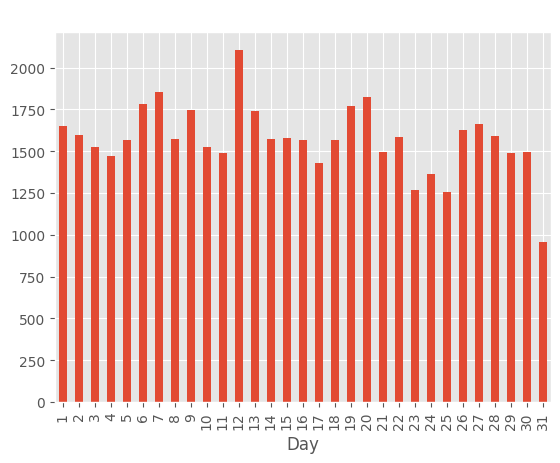

In [5]:

tweetInfo.value_counts('Day').sort_index().plot(kind='bar', title='Tweets by Day')

<AxesSubplot: title={'center': 'Tweets by Month'}, xlabel='Month'>

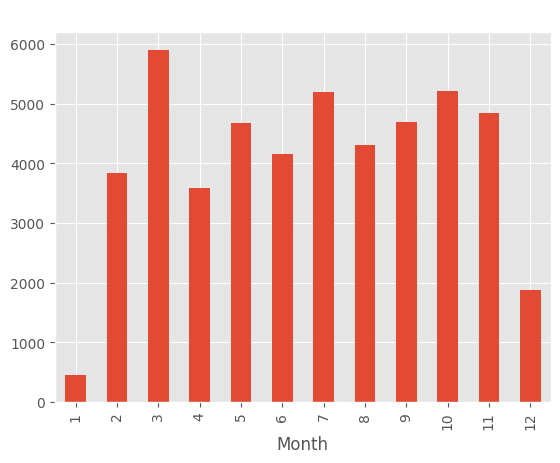

In [6]:

tweetInfo.value_counts('Month').sort_index().plot(kind='bar', title='Tweets by Month')

<AxesSubplot: title={'center': 'Tweets by Week'}, xlabel='wkofYr'>

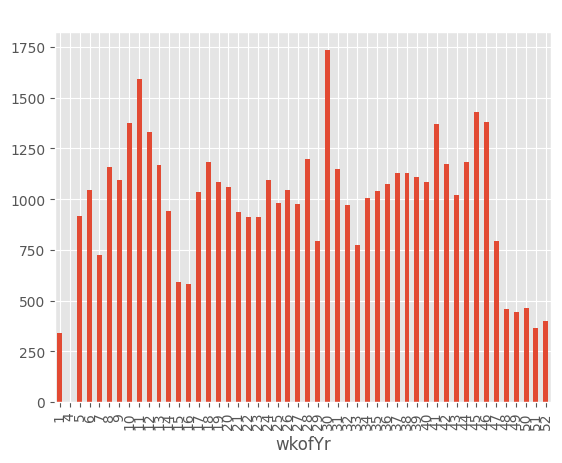

In [7]:
tweetInfo.value_counts('wkofYr').sort_index().plot(kind='bar', title='Tweets by Week')

As we can see January is missing data from a couple of weeks 
This is an issue with the data source and can't be recitified by going back to the data
The plan is too sample 1000 rows from the data frame and add them in january 
Also I am going to drop the year value as other months are missing days 

In [8]:
# use a boolean mask to filter the data
mask = (tweetInfo['Month'] != 1) & (tweetInfo['wkofYr'] > 5)
sampledData = tweetInfo[mask].sample(1200)


sampledData.loc[:, 'Month'] = 1
sampledData.loc[:, 'wkofYr'] = 0 # so the next line spreads the data evenly
sampledData['wkofYr'] = pd.to_datetime(sampledData[['Year', 'Month', 'Day']]).dt.weekofyear


C:\Users\stehayes\AppData\Local\Temp\ipykernel_7996\201084437.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  sampledData['wkofYr'] = pd.to_datetime(sampledData[['Year', 'Month', 'Day']]).dt.weekofyear


<AxesSubplot: title={'center': 'Tweets by Week'}, xlabel='wkofYr'>

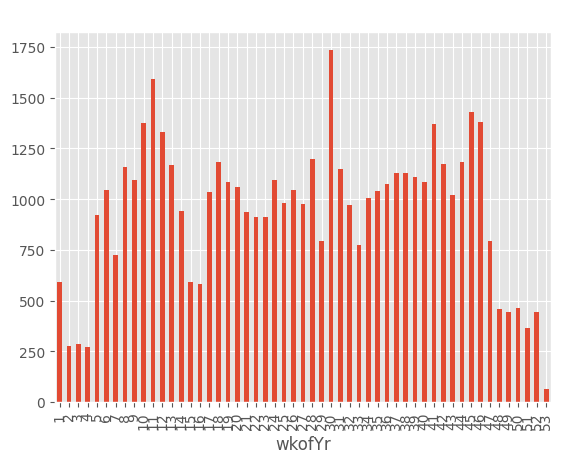

In [9]:
tweetInfo = pd.concat([sampledData, tweetInfo])
tweetInfo.value_counts('wkofYr').sort_index().plot(kind='bar', title='Tweets by Week')

Get ready for the time series model

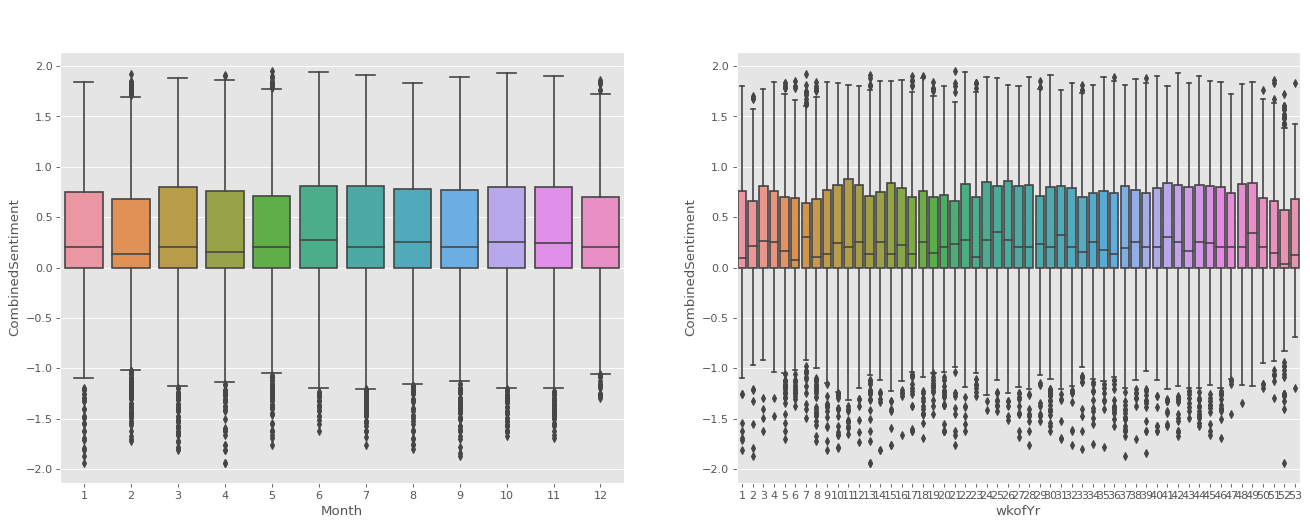

In [10]:
import seaborn as sns
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='Month', y='CombinedSentiment', data=tweetInfo, ax=axes[0])
sns.boxplot(x='wkofYr', y='CombinedSentiment', data=tweetInfo)

# Set Title
axes[0].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18); 
axes[1].set_title('Week-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
%matplotlib inline
# Create and end of week frequency
df = tweetInfo[['created_at', 'txbSentiment', 'vaderSentiment', 'CombinedSentiment']]
# the two lines below are to make sure the date is in the right format
df['date'] = pd.to_datetime(df['created_at'])
df = df.set_index('date')


C:\Users\stehayes\AppData\Local\Temp\ipykernel_7996\2423307534.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['created_at'])


In [12]:
df = df.resample('W').mean()

missing = df.isnull()
missing.head()

C:\Users\stehayes\AppData\Local\Temp\ipykernel_7996\4222316919.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.resample('W').mean()


,txbSentiment,vaderSentiment,CombinedSentiment
date,,,
2021-01-31 00:00:00+00:00,False,False,False
2021-02-07 00:00:00+00:00,False,False,False
2021-02-14 00:00:00+00:00,False,False,False
2021-02-21 00:00:00+00:00,False,False,False
2021-02-28 00:00:00+00:00,False,False,False


In [13]:
df = df.interpolate(method='linear', axis=0)
df.isnull().sum()

txbSentiment         0
vaderSentiment       0
CombinedSentiment    0
dtype: int64

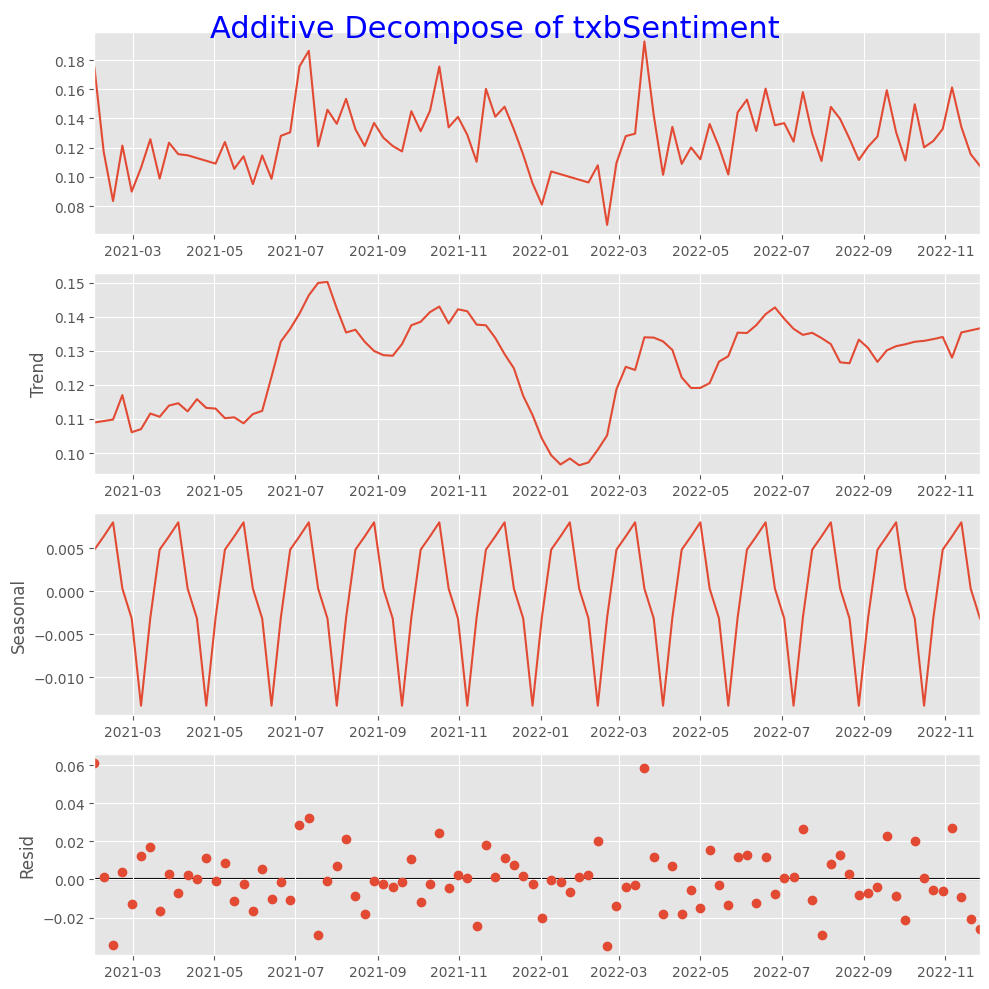

,seas,trend,resid,actual_values
date,,,,
2021-01-31 00:00:00+00:00,0.004843,0.108946,0.061212,0.175000
2021-02-07 00:00:00+00:00,0.006393,0.109379,0.001303,0.117075
2021-02-14 00:00:00+00:00,0.008028,0.109812,-0.034395,0.083444
2021-02-21 00:00:00+00:00,0.000310,0.116980,0.004165,0.121455
2021-02-28 00:00:00+00:00,-0.003175,0.106096,-0.013007,0.089914


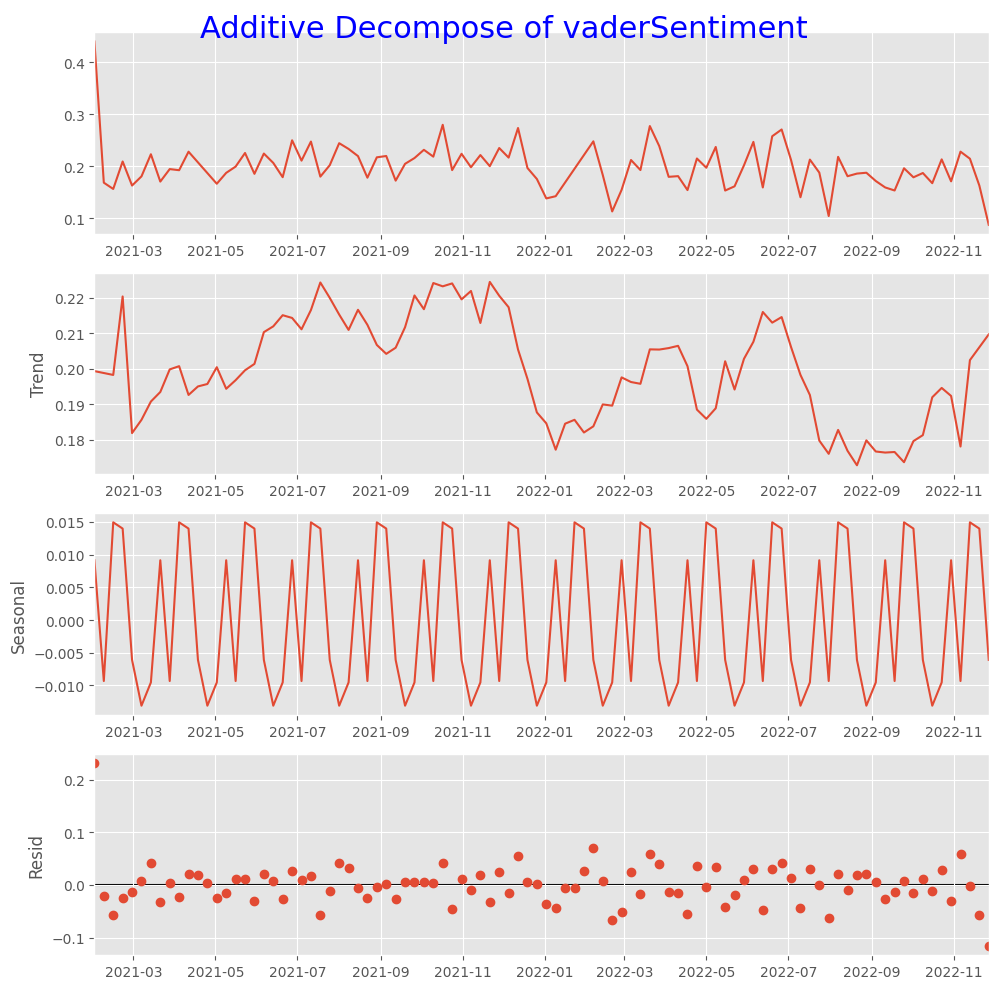

,seas,trend,resid,actual_values
date,,,,
2021-01-31 00:00:00+00:00,0.009142,0.199317,0.231940,0.440400
2021-02-07 00:00:00+00:00,-0.009327,0.198775,-0.020752,0.168695
2021-02-14 00:00:00+00:00,0.014940,0.198232,-0.056607,0.156565
2021-02-21 00:00:00+00:00,0.013985,0.220356,-0.024887,0.209454
2021-02-28 00:00:00+00:00,-0.006099,0.181839,-0.012564,0.163176


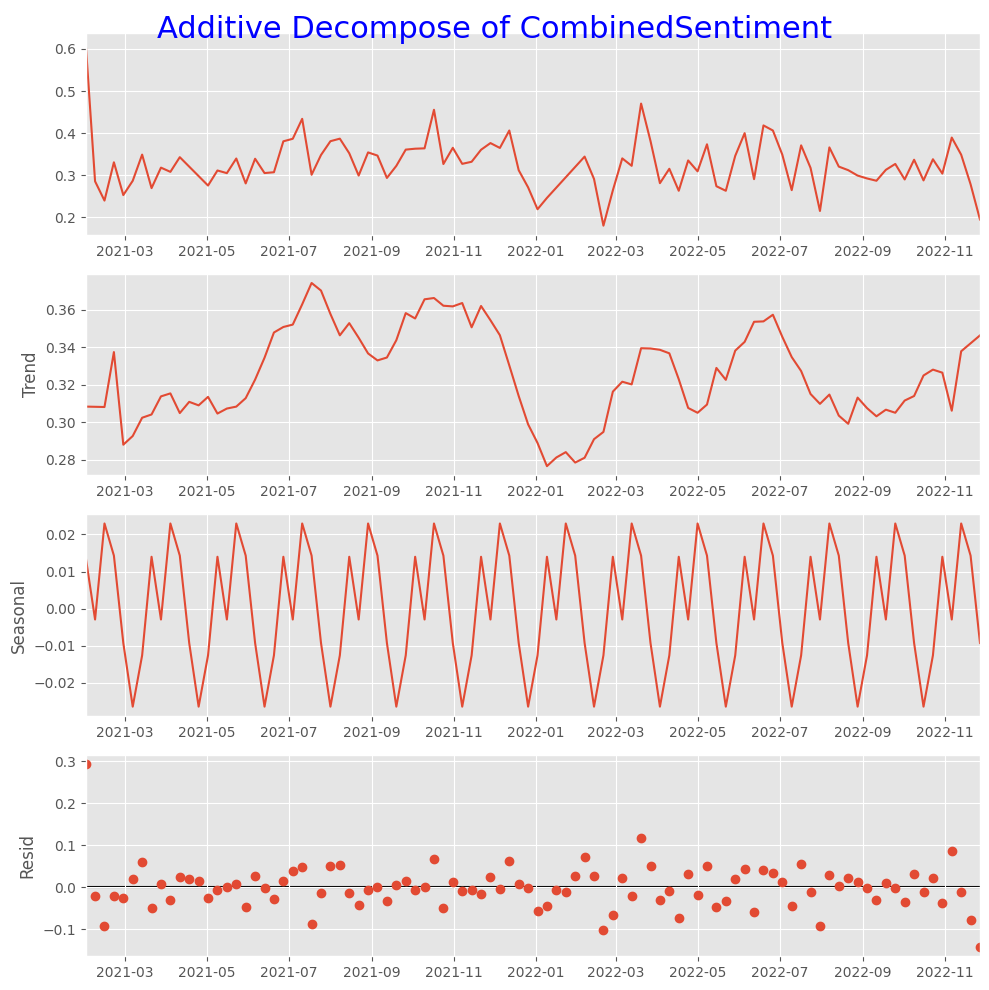

,seas,trend,resid,actual_values
date,,,,
2021-01-31 00:00:00+00:00,0.013985,0.308263,0.293152,0.615400
2021-02-07 00:00:00+00:00,-0.002935,0.308154,-0.019449,0.285770
2021-02-14 00:00:00+00:00,0.022968,0.308044,-0.091003,0.240009
2021-02-21 00:00:00+00:00,0.014295,0.337337,-0.020722,0.330909
2021-02-28 00:00:00+00:00,-0.009274,0.287936,-0.025571,0.253091


In [14]:
# function to display trends and seasonality
def plot_trend_seasonality(df, col):
    # Additive Decomposition
    result_add = seasonal_decompose(df[col], model='additive', extrapolate_trend='freq' , period=7)

    # Plot
    plt.rcParams.update({'figure.figsize': (10,10)})
    # result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
    # add the title to the plot
    
    result_add.plot().suptitle('Additive Decompose of ' + col, fontsize=22, color='blue')
    plt.show()
    # Extract the Components ----
    # Actual Values = Product of (Seasonal * Trend * Resid)
    df_reconstructed = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
    df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
    display(df_reconstructed.head())



for i in ['txbSentiment', 'vaderSentiment', 'CombinedSentiment']:
    plot_trend_seasonality(df, i)

    
#df = df.set_index('date').asfreq('D')
# Multiplicative Decomposition  Multiplicative seasonality is not appropriate for zero and negative values
# result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')



Test for Stationary Seasonality using Augmented Dickey Fuller test (ADH Test)

In [15]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.txbSentiment.values)
print ("TextBlob Sentiment ADF Test")
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] > 0.05:
    print('Probably not Stationary')
else:
    print('Probably Stationary')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

result = adfuller(df.vaderSentiment.values)

print ("\n Vader Sentiment ADF Test")
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}') 
if result[1] > 0.05:
    print('Probably not Stationary')
else:
    print('Probably Stationary')

for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

result = adfuller(df.CombinedSentiment.values)

print ("\n Combined Sentiment ADF Test")
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}') 
if result[1] > 0.05:
    print('Probably not Stationary')
else:
    print('Probably Stationary')

for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

TextBlob Sentiment ADF Test
ADF Statistic: -6.669888672338992
p-value: 4.616337190224359e-09
Probably Stationary
Critial Values:
   1%, -3.5011373281819504
Critial Values:
   5%, -2.8924800524857854
Critial Values:
   10%, -2.5832749307479226

 Vader Sentiment ADF Test
ADF Statistic: -2.43323178973566
p-value: 0.13257577551088173
Probably not Stationary
Critial Values:
   1%, -3.506057133647011
Critial Values:
   5%, -2.8946066061911946
Critial Values:
   10%, -2.5844100201994697

 Combined Sentiment ADF Test
ADF Statistic: -9.059782447347454
p-value: 4.596363404610128e-15
Probably Stationary
Critial Values:
   1%, -3.5011373281819504
Critial Values:
   5%, -2.8924800524857854
Critial Values:
   10%, -2.5832749307479226


No trend is visible in the previous charts in this data

lets check for seasonality 

In [16]:

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


def plot_acf_pacf(df, col):
    # Calculate ACF and PACF upto 50 lags
    # acf_50 = acf(df.value, nlags=50)
    # pacf_50 = pacf(df.value, nlags=50)

    # Draw Plot
    fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
    # titles
    axes[0].set_title('Autocorrelation ' + col, color='blue')
    plot_acf(df[col].tolist(), lags=40, ax=axes[0])
    axes[1].set_title('Partial Autocorrelation ' + col, color='blue')
    plot_pacf(df[col].tolist(), lags=40, ax=axes[1], method='ywm')

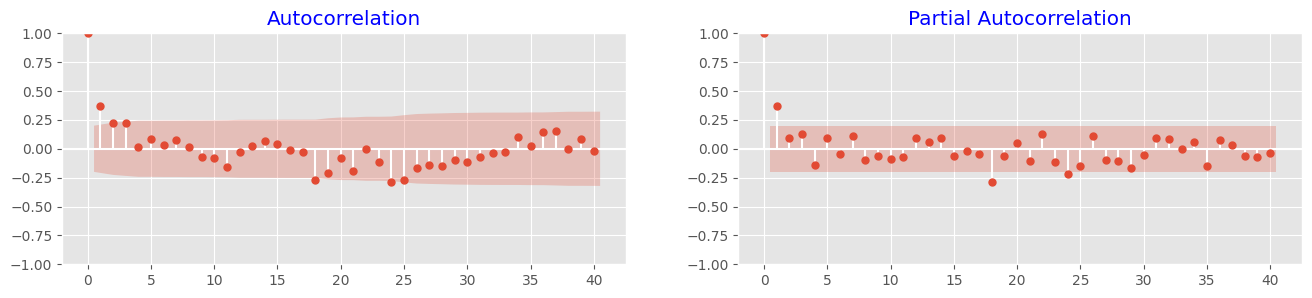

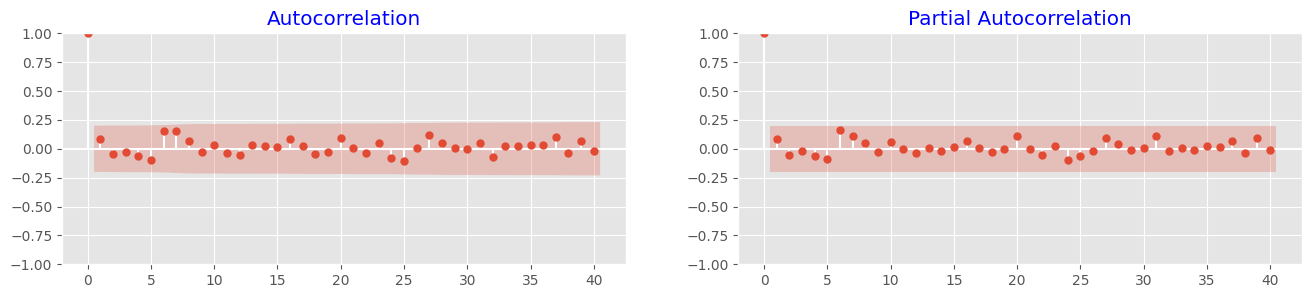

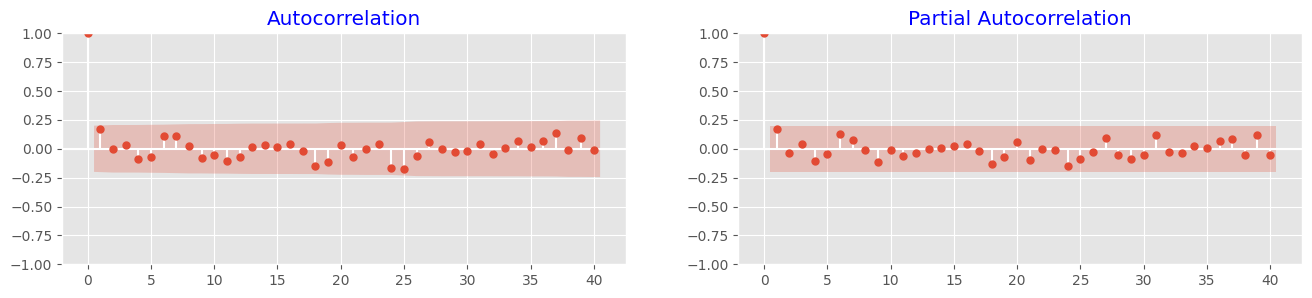

In [17]:
for i in ['txbSentiment', 'vaderSentiment', 'CombinedSentiment']:
    plot_acf_pacf(df, i)

Scatter plots showing the lag correlation

In [18]:
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

def plot_lag(df, col):
    # Plot
    fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
    for i, ax in enumerate(axes.flatten()[:4]):
        lag_plot(df[col], lag=i+1, ax=ax, c='firebrick')
        ax.set_title('Lag ' + str(i+1) , color='blue')
        

    fig.suptitle('Lag Plots of Tweet Sentiment ' + col + '\n(Wider more scattered points -> lesser correlation)\n', y=1.15, color='blue')
    plt.show()

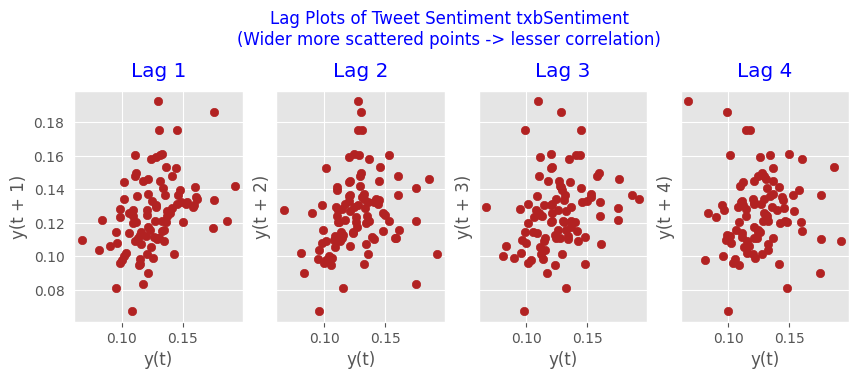

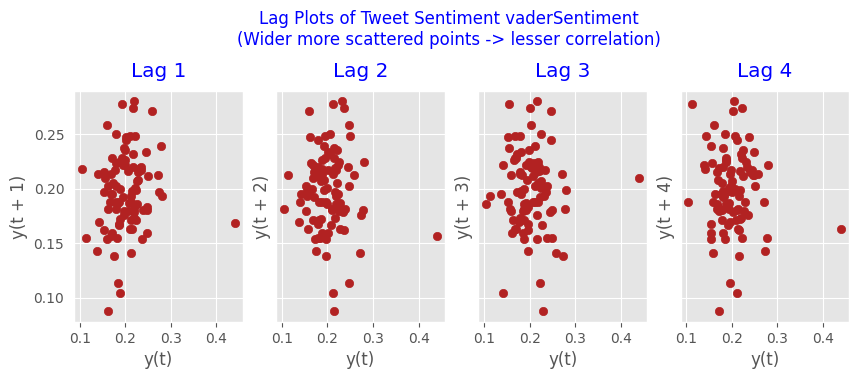

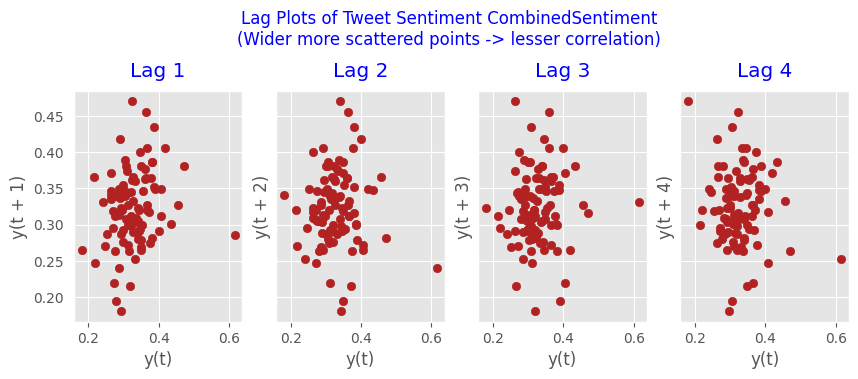

In [19]:
for i in ['txbSentiment', 'vaderSentiment', 'CombinedSentiment']:
    plot_lag(df, i)

Entropy 

In [20]:
import numpy as np
rand_small = np.random.randint(0, 100, size=48)
rand_big = np.random.randint(0, 100, size=96)

def SampEn(U, m, r):
    """Compute Sample entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))



In [21]:
print(SampEn(df.txbSentiment, m=2, r=0.2*np.std(df.txbSentiment)))  

print(SampEn(rand_small, m=2, r=0.2*np.std(rand_small)))  
print(SampEn(rand_big, m=2, r=0.2*np.std(rand_big)))      

1.6422277352570913
inf
2.639057329615259


C:\Users\stehayes\AppData\Local\Temp\ipykernel_7996\3832917519.py:16: RuntimeWarning: divide by zero encountered in log
  return -np.log(_phi(m+1) / _phi(m))


Granger Causality 

In [22]:
from statsmodels.tsa.stattools import grangercausalitytests

# got an error when trying to use the date, as it was the index
df = df.reset_index()

df['month'] = df.date.dt.month
grangercausalitytests(df[['txbSentiment', 'month']], maxlag=4)




Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8307  , p=0.0305  , df_denom=92, df_num=1
ssr based chi2 test:   chi2=4.9882  , p=0.0255  , df=1
likelihood ratio test: chi2=4.8617  , p=0.0275  , df=1
parameter F test:         F=4.8307  , p=0.0305  , df_denom=92, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4177  , p=0.2477  , df_denom=89, df_num=2
ssr based chi2 test:   chi2=2.9947  , p=0.2237  , df=2
likelihood ratio test: chi2=2.9480  , p=0.2290  , df=2
parameter F test:         F=1.4177  , p=0.2477  , df_denom=89, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4206  , p=0.7387  , df_denom=86, df_num=3
ssr based chi2 test:   chi2=1.3645  , p=0.7139  , df=3
likelihood ratio test: chi2=1.3546  , p=0.7162  , df=3
parameter F test:         F=0.4206  , p=0.7387  , df_denom=86, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5391  , p=0.7074  , df_d

{1: ({'ssr_ftest': (4.830682415104872, 0.030467433501501936, 92.0, 1),
   'ssr_chi2test': (4.988204667771335, 0.025520673903798283, 1),
   'lrtest': (4.861656740281205, 0.0274599549505477, 1),
   'params_ftest': (4.8306824151049, 0.03046743350150163, 92.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.4177102314343422, 0.24768548835928994, 89.0, 2),
   'ssr_chi2test': (2.99471374729951, 0.22372070144808842, 2),
   'lrtest': (2.9479995459948896, 0.22900767218509135, 2),
   'params_ftest': (1.4177102314344086, 0.2476854883592762, 89.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.4206136664732248, 0.7386735544327161, 86.0, 3),
   'ssr_chi2test': (1.3645489877445314, 0.7138652729299204, 3),
   'lrtest': (1.354635124550441, 0.7162020925095489, 3),
   'params_ftest': (0.42061366647326803, 0.738673554432686, 86.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0.,

In [23]:
df['week'] = df.date.dt.week
grangercausalitytests(df[['txbSentiment', 'week']], maxlag=4)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7780  , p=0.0550  , df_denom=92, df_num=1
ssr based chi2 test:   chi2=3.9012  , p=0.0483  , df=1
likelihood ratio test: chi2=3.8233  , p=0.0505  , df=1
parameter F test:         F=3.7780  , p=0.0550  , df_denom=92, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1452  , p=0.3228  , df_denom=89, df_num=2
ssr based chi2 test:   chi2=2.4191  , p=0.2983  , df=2
likelihood ratio test: chi2=2.3885  , p=0.3029  , df=2
parameter F test:         F=1.1452  , p=0.3228  , df_denom=89, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2746  , p=0.8436  , df_denom=86, df_num=3
ssr based chi2 test:   chi2=0.8908  , p=0.8277  , df=3
likelihood ratio test: chi2=0.8865  , p=0.8287  , df=3
parameter F test:         F=0.2746  , p=0.8436  , df_denom=86, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7108  , p=0.5869  , df_d

C:\Users\stehayes\AppData\Local\Temp\ipykernel_7996\4239364594.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week'] = df.date.dt.week


{1: ({'ssr_ftest': (3.7780375936717734, 0.05498554384476094, 92.0, 1),
   'ssr_chi2test': (3.9012344717262883, 0.04825064134374727, 1),
   'lrtest': (3.823258752121774, 0.050545841383928855, 1),
   'params_ftest': (3.7780375936699113, 0.054985543844819726, 92.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.1452093628539703, 0.32280030519132, 89.0, 2),
   'ssr_chi2test': (2.4190939350173752, 0.2983324030916836, 2),
   'lrtest': (2.388490142266164, 0.3029325604151501, 2),
   'params_ftest': (1.145209362853811, 0.3228003051913656, 89.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.27457629264269096, 0.8435867832733969, 86.0, 3),
   'ssr_chi2test': (0.8907765772943113, 0.8276530437844589, 3),
   'lrtest': (0.8865375866986369, 0.8286753240660638, 3),
   'params_ftest': (0.274576292642766, 0.843586783273341, 86.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0.

Predicting Sentiment at last!

In [24]:
import pandas as pd 
import pandas_datareader as web 
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA

In [25]:
#split the data into train and training set
#(df['date'].max() - df['date'].min()) *0.7
df_old = df.copy()
# dropping columns that have proved to be problematic
df = df.drop(['vaderSentiment', 'week', 'month', 'CombinedSentiment'], axis=1)

train = df[df['date'] < df['date'].min() + (df['date'].max() - df['date'].min()) *0.7]
test = df[df['date'] >= df['date'].min() + (df['date'].max() - df['date'].min()) *0.7]

train['date'] = pd.to_datetime(train['date']) # making sure the date is in the right format
train = train.set_index('date')

test['date'] = pd.to_datetime(test['date']) # making sure the date is in the right format
test = test.set_index('date')


C:\Users\stehayes\AppData\Local\Temp\ipykernel_7996\479954875.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['date'] = pd.to_datetime(train['date']) # making sure the date is in the right format
C:\Users\stehayes\AppData\Local\Temp\ipykernel_7996\479954875.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['date'] = pd.to_datetime(test['date']) # making sure the date is in the right format


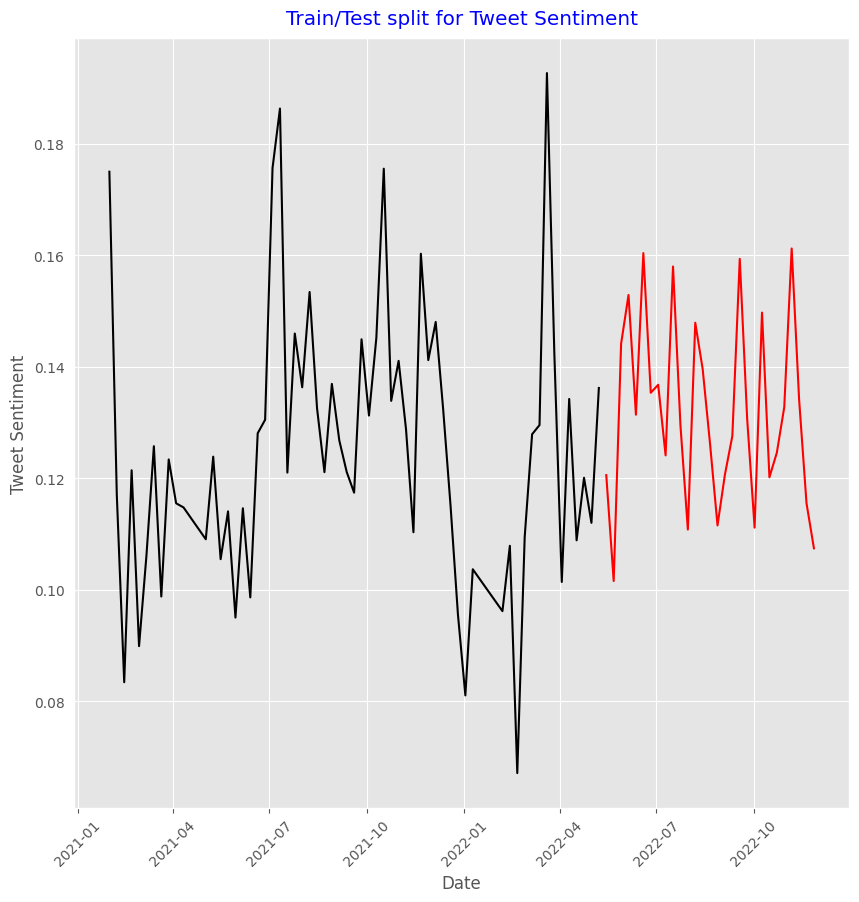

In [26]:
plt.plot(train['txbSentiment'], color = "black", label = 'Training')
plt.plot(test['txbSentiment'], color = "red", label = 'Testing')
plt.ylabel('Tweet Sentiment')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Tweet Sentiment", color = "blue")
plt.show()

y = train['txbSentiment']


## Grid Search for the best model

Taken from here https://towardsdev.com/auto-arima-hyperparameter-search-ab991a21c2bd

In [27]:
import itertools
import warnings
warnings.filterwarnings('ignore')
# Grid Search
p = d = q = range(0,3) # p, d, and q can be either 0, 1, or 2
pdq = list(itertools.product(p,d,q)) # gets all possible combinations of p, d, and q 
ARMA_pdq = [x for x in pdq if x[1] == 0] # since ARMA models don't have a differencing term, we only want the combinations where d = 0
p2 = d2 = q2 = range(0, 6) # second set of p's, d's, and q's for seasonal parameters
s = 12 

pdq2 = list(itertools.product(p2,d2,q2)) # similar to code above but for seasonal parameters

pdqs2 = [(c[0], c[1], c[2], s) for c in pdq2]


In [28]:
# Grid search continued for ARMA
ARMA_combs = {}
ARMA_rmseDict = {}
ARMA_aics = []
ARMA_rmses = []

for combination in ARMA_pdq:
    try:
        ARMAmodel = SARIMAX(y, order = combination)
        ARMAmodel = ARMAmodel.fit(disp=False)
        ARMA_combs.update({ARMAmodel.aic : [combination]})
        ARMA_aics.append(ARMAmodel.aic)
        ARMA_rmseDict.update({np.sqrt(ARMAmodel.mse): [combination]})
        ARMA_rmses.append(np.sqrt(ARMAmodel.mse))
        #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(combination, seasonal_combination, model.aic))
           
    except:
        continue
            
ARMA_best_aic = min(ARMA_aics)
display(ARMA_best_aic)
display(ARMA_combs[ARMA_best_aic])
ARMA_best_rmse = min(ARMA_rmses)
display(ARMA_best_rmse)
display(ARMA_rmseDict[ARMA_best_rmse])
        

-300.55806109081016

[(2, 0, 1)]

0.03157359715389442

[(2, 0, 1)]

In [29]:
# Grid search continued for ARIMAmodel
ARIMA_combs = {}
ARIMA_rmseDict = {}
ARIMA_aics = []
ARIMA_rmses = []
for combination in pdq:
    try:
        ARIMAmodel = SARIMAX(y, order = combination)
        ARIMAmodel = ARIMAmodel.fit(disp=False)
        ARIMA_combs.update({ARIMAmodel.aic : [combination]})
        ARIMA_aics.append(ARIMAmodel.aic)
        ARIMA_rmseDict.update({np.sqrt(ARIMAmodel.mse): [combination]})
        ARIMA_rmses.append(np.sqrt(ARIMAmodel.mse))
        #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(combination, seasonal_combination, model.aic))
           
    except:
        continue
            
ARIMA_best_aic = min(ARIMA_aics)
display(ARIMA_best_aic)
display(ARIMA_combs[ARIMA_best_aic])
ARIMA_best_rmse = min(ARIMA_rmses)
display(ARIMA_best_rmse)
display(ARIMA_rmseDict[ARIMA_best_rmse])
        

-301.9497147946607

[(1, 1, 1)]

0.03157359715389442

[(2, 0, 1)]

In [30]:
# Grid Search Continued for SARIMAX
SARIMAX_combs = {}
SARIMAX_rmseDict = {}
SARIMAX_aics = []
SARIMAX_rmses = []
for combination in pdq:
    for seasonal_combination in pdqs2:
        try:
            SARIMAXmodel = SARIMAX(y, order=combination, seasonal_order=seasonal_combination)
            SARIMAXmodel = SARIMAXmodel.fit(disp=False)
            SARIMAX_combs.update({SARIMAXmodel.aic : [combination, seasonal_combination]})
            SARIMAX_aics.append(SARIMAXmodel.aic)
            SARIMAX_rmseDict.update({np.sqrt(SARIMAXmodel.mse): [combination, seasonal_combination]})
            SARIMAX_rmses.append(np.sqrt(SARIMAXmodel.mse))
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(combination, seasonal_combination, model.aic))
            
        except:
            continue
            
SARIMAX_best_aic = min(SARIMAX_aics)
display(SARIMAX_best_aic)
display(SARIMAX_combs[SARIMAX_best_aic])
SARIMAX_best_rmse = min(SARIMAX_rmses)
display(SARIMAX_best_rmse)
display(SARIMAX_rmseDict[SARIMAX_best_rmse])

### Arma

c:\Program Files\Python39\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python39\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python39\tf\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


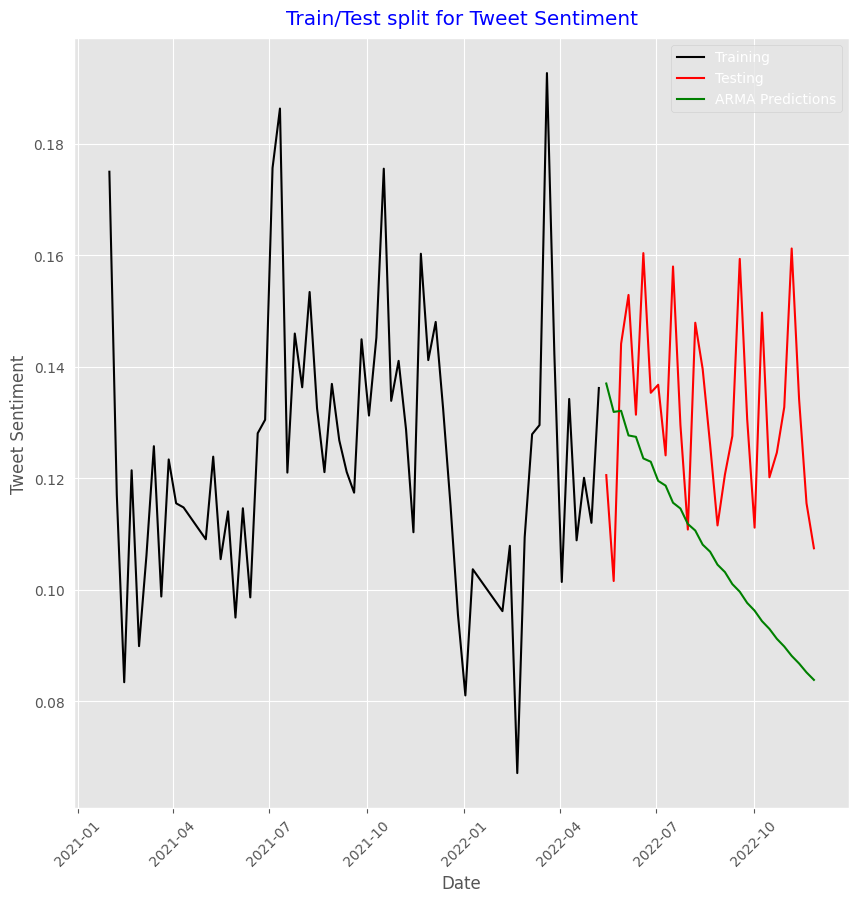

RMSE for ARMA model:  0.033045582489154


In [27]:


ARMAmodel = SARIMAX(y, order = (2, 0, 1))
ARMAmodel = ARMAmodel.fit()

y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], 
                                             end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_outARMA = y_pred_df["Predictions"] 

plt.plot(train['txbSentiment'], color = "black", label = 'Training')
plt.plot(test['txbSentiment'], color = "red", label = 'Testing')
plt.ylabel('Tweet Sentiment')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Tweet Sentiment", color = "blue")
plt.plot(y_pred_outARMA, color='green', label = 'ARMA Predictions')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(ARMAmodel.mse)
print("RMSE for ARMA model: ", arma_rmse)

### Arima

c:\Program Files\Python39\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python39\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


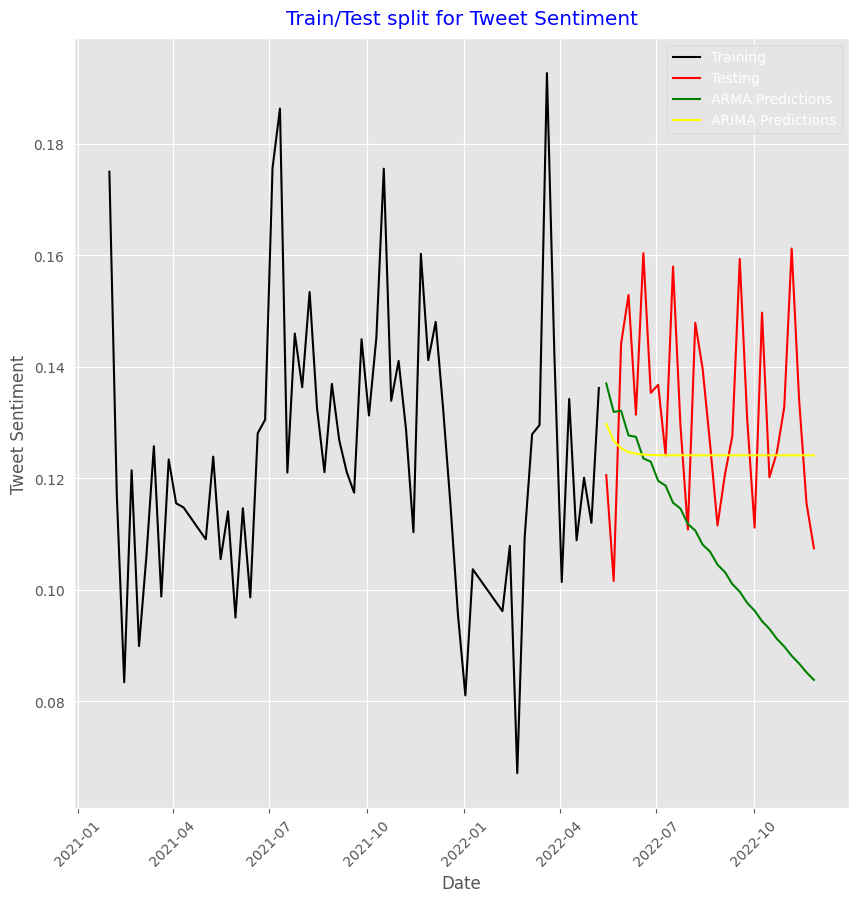

ARIMA RMSE:  0.03121125307514413


In [28]:
y = train['txbSentiment']

ARIMAmodel = SARIMAX(y, order = (1, 1, 1))
#ARIMAmodel = SARIMAX(y, order = (2, 3, 2))
#ARIMAmodel = SARIMAX(y, order = (5, 4, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0],
                                              end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_outARIMA = y_pred_df["Predictions"]

plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.ylabel('Tweet Sentiment')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Tweet Sentiment", color = "blue")
plt.plot(y_pred_outARMA, color='green', label = 'ARMA Predictions')
plt.plot(y_pred_outARIMA, color='Yellow', label = 'ARIMA Predictions')
plt.legend()
plt.show()

arima_rmse = np.sqrt(ARIMAmodel.mse)
print("ARIMA RMSE: ",arima_rmse)

 ### Sarima

c:\Program Files\Python39\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python39\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python39\tf\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Program Files\Python39\tf\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


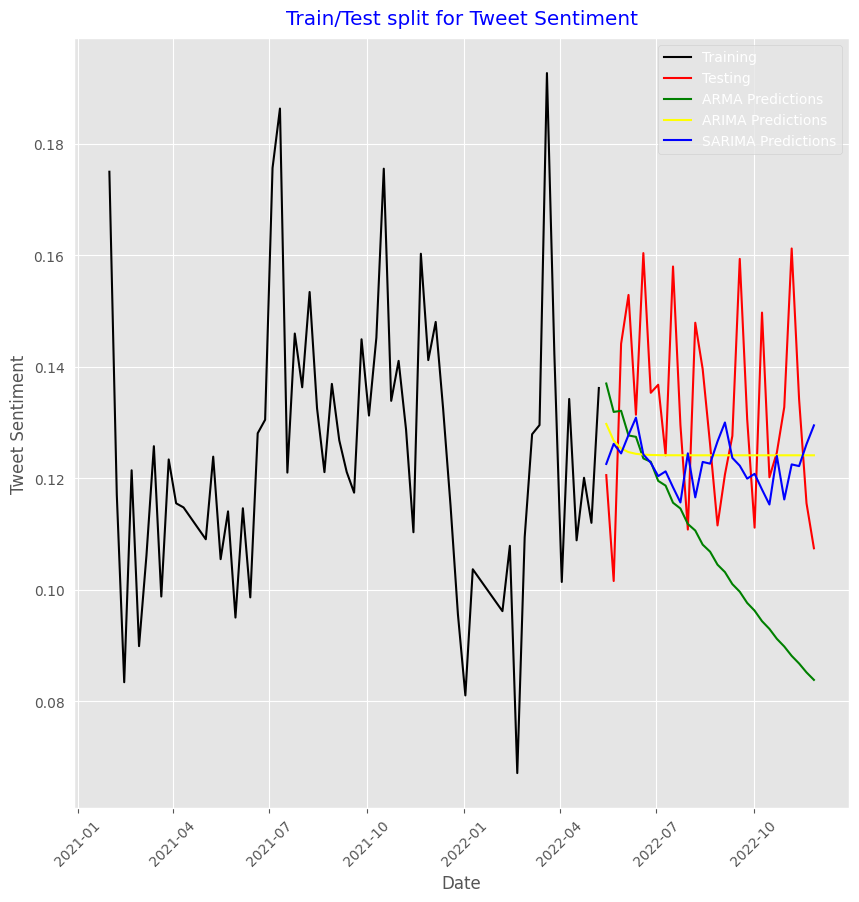

SARIMA RMSE:  0.03096884477697612


In [29]:
SARIMAXmodel = SARIMAX(y, order = (2,0,1), seasonal_order=(1, 0, 1, 12))
SARIMAXmodel = SARIMAXmodel.fit()

y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0],
                                                end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_outSARIMAX = y_pred_df["Predictions"] 
plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.ylabel('Tweet Sentiment')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Tweet Sentiment", color = "blue")
plt.plot(y_pred_outARMA, color='green', label = 'ARMA Predictions')
plt.plot(y_pred_outARIMA, color='Yellow', label = 'ARIMA Predictions')
plt.plot(y_pred_outSARIMAX, color='Blue', label = 'SARIMA Predictions')
plt.legend()
plt.show()

sarima_rmse = np.sqrt(SARIMAXmodel.mse)
print("SARIMA RMSE: ",sarima_rmse)

SARIMAX model wins the right predict txbSentiment

In [30]:
# Updat the model with all of the data 
dfSentiment = pd.concat([train, test], axis = 0)
y = dfSentiment['txbSentiment'] 

SARIMAXmodel = SARIMAX(y, order = (2,0,1), seasonal_order=(1, 0, 1, 12))
SARIMAXmodel = SARIMAXmodel.fit()

c:\Program Files\Python39\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python39\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python39\tf\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Program Files\Python39\tf\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [31]:
week1 = SARIMAXmodel.predict(start = len(dfSentiment)-1, end = len(dfSentiment)) #.conf_int(alpha = 0.01)
week4 = SARIMAXmodel.predict(start = len(dfSentiment), end = len(dfSentiment) + 4) #.conf_int(alpha = 0.01)
week12 = SARIMAXmodel.predict(start = len(dfSentiment), end = len(dfSentiment) + 12) #.conf_int(alpha = 0.01)

In [32]:
display(week1)
display(week4)
display(week12)

2022-11-27 00:00:00+00:00    0.124744
2022-12-04 00:00:00+00:00    0.119501
Freq: W-SUN, Name: predicted_mean, dtype: float64

2022-12-04 00:00:00+00:00    0.119501
2022-12-11 00:00:00+00:00    0.121845
2022-12-18 00:00:00+00:00    0.122860
2022-12-25 00:00:00+00:00    0.122884
2023-01-01 00:00:00+00:00    0.122081
Freq: W-SUN, Name: predicted_mean, dtype: float64

2022-12-04 00:00:00+00:00    0.119501
2022-12-11 00:00:00+00:00    0.121845
2022-12-18 00:00:00+00:00    0.122860
2022-12-25 00:00:00+00:00    0.122884
2023-01-01 00:00:00+00:00    0.122081
2023-01-08 00:00:00+00:00    0.123068
2023-01-15 00:00:00+00:00    0.121100
2023-01-22 00:00:00+00:00    0.121725
2023-01-29 00:00:00+00:00    0.120093
2023-02-05 00:00:00+00:00    0.119772
2023-02-12 00:00:00+00:00    0.119036
2023-02-19 00:00:00+00:00    0.118323
2023-02-26 00:00:00+00:00    0.118329
Freq: W-SUN, Name: predicted_mean, dtype: float64

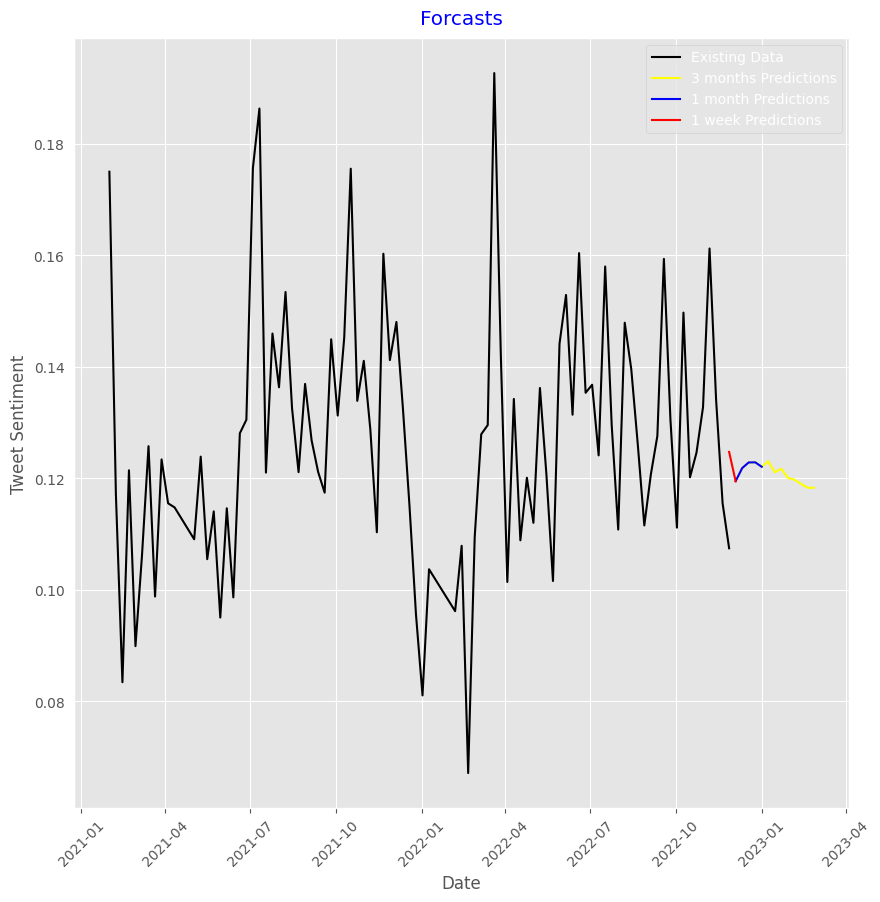

In [33]:
plt.plot(dfSentiment, color = "black", label = 'Existing Data')
plt.ylabel('Tweet Sentiment')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Forcasts", color = "blue")

plt.plot(week12, color='Yellow', label = '3 months Predictions')
plt.plot(week4, color='Blue', label = '1 month Predictions')
plt.plot(week1, color='red', label = '1 week Predictions')
plt.legend()
plt.show()

In [35]:
week12 = pd.DataFrame(week12)

week12.reset_index(inplace = True)

In [36]:
week12.head()

,index,predicted_mean
0,2022-12-04 00:00:00+00:00,0.119501
1,2022-12-11 00:00:00+00:00,0.121845
2,2022-12-18 00:00:00+00:00,0.122860
3,2022-12-25 00:00:00+00:00,0.122884
4,2023-01-01 00:00:00+00:00,0.122081


In [38]:
# Rename column 'index' to 'date'
week12 = week12.rename(columns={'index': 'date'})
# Rename column 'predicted_mean' to 'txbSentiment'
week12 = week12.rename(columns={'predicted_mean': 'txbSentiment'})


week12.head()

,date,txbSentiment
0,2022-12-04 00:00:00+00:00,0.119501
1,2022-12-11 00:00:00+00:00,0.121845
2,2022-12-18 00:00:00+00:00,0.122860
3,2022-12-25 00:00:00+00:00,0.122884
4,2023-01-01 00:00:00+00:00,0.122081


In [41]:
df.head()

,date,txbSentiment
0,2021-01-31 00:00:00+00:00,0.175000
1,2021-02-07 00:00:00+00:00,0.117075
2,2021-02-14 00:00:00+00:00,0.083444
3,2021-02-21 00:00:00+00:00,0.121455
4,2021-02-28 00:00:00+00:00,0.089914


In [49]:
dfSentiment = df.append( week12, ignore_index = True)



C:\Users\stehayes\AppData\Local\Temp\ipykernel_7996\2823754566.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfSentiment = df.append( week12, ignore_index = True)


In [50]:
dfSentiment.head()

,date,txbSentiment
0,2021-01-31 00:00:00+00:00,0.175000
1,2021-02-07 00:00:00+00:00,0.117075
2,2021-02-14 00:00:00+00:00,0.083444
3,2021-02-21 00:00:00+00:00,0.121455
4,2021-02-28 00:00:00+00:00,0.089914


In [ ]:
dfSentiment.to_csv("./Data/dfSentiment.csv")

# Dashboard

In [47]:
import panel as pn
import pandas as pd
import bokeh as bk

pn.extension(size_policy='stretch_width', design='material', template = 'fast')
pn.state.template.param.update(title = "Tweet Sentiment Analysis")

forecast = pn.widgets.Select(name='Forecast', options=['none', '1 week', '1 month', '3 months'])

In [60]:
twtsent = pd.read_csv("./Data/TweetInfo.csv")
dfSent = pd.read_csv("./Data/dfSentiment.csv")
start_date = "2021-01-31"
end_date = "2022-11-27"
mask = (dfSent["date"] >= start_date) & (dfSent["date"] <= end_date)
df_original = dfSent.loc[mask]

end_date = "2022-12-11"
mask = (dfSent["date"] >= start_date) & (dfSent["date"] <= end_date)
df_1week = dfSent.loc[mask]

end_date = "2022-12-28"
mask = (dfSent["date"] >= start_date) & (dfSent["date"] <= end_date)
df_1month = dfSent.loc[mask]

def ret_Data(forecast):
    if forecast == "none":
        return df_original[['date','txbSentiment']].sort_values(by=['date'], ascending = False)
    elif forecast == "1 week":
        return df_1week[['date','txbSentiment']].sort_values(by=['date'], ascending = False)
    elif forecast == "1 month":
        return df_1month[['date','txbSentiment']].sort_values(by=['date'], ascending = False)
    elif forecast == "3 months":
        return  dfSent[['date','txbSentiment']].sort_values(by=['date'], ascending = False)


In [61]:


pn.Row(
    pn.Row(
        pn.Column("Number of tweets: ",len(twtsent["id"])),
        pn.Column("Number of tweets by Likert Scale: \n", twtsent["LikertScale"].value_counts()),
        pn.Column(forecast).servable()
    ),
    pn.Row(
        pn.bind(ret_Data, forecast),
    ).servable(),
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'281278a7-5566-49e4-8dcf-3f2446444034': {'version…

Row(design=<class 'panel.theme.materi...)
    [0] Row(design=<class 'panel.theme.materi...)
        [0] Column(design=<class 'panel.theme.materi...)
            [0] Markdown(str, design=<class 'panel.theme.materi...)
            [1] Str(int, design=<class 'panel.theme.materi...)
        [1] Column(design=<class 'panel.theme.materi...)
            [0] Markdown(str, design=<class 'panel.theme.materi...)
            [1] DataFrame(Series, design=<class 'panel.theme.materi...)
        [2] Column(design=<class 'panel.theme.materi...)
            [0] Select(design=<class 'panel.theme.materi..., name='Forecast', options=['none', '1 week', ...], value='none')
    [1] Row(design=<class 'panel.theme.materi...)
        [0] ParamFunction(function, _pane=DataFrame, design=<class 'panel.theme.materi...)